# Optional part of code

Only needed if it is run on Google colab systems

In [0]:
#Files are in Google Drive, so we must make a connection by authorization
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Check if and which drive is mounted 
import os
os.chdir("/content/drive/")
!ls

'My Drive'


# 1. Load modules and packages

In [0]:
# Import necessary modules and install the ones that are not in Colab
# Likewise, if not working on Colab, remove '!' before 'pip install'

!pip install glob3
!pip install scipy==1.1.0
!pip install imgaug==0.2.6
import os
import numpy as np
import glob
import scipy
import scipy.ndimage
import scipy.misc
import re
import pandas as pd





  Created wheel for glob3: filename=glob3-0.0.1-cp36-none-any.whl size=1680 sha256=d7cdefe9d9616ea452fbdb2d09c371623d99082c165a851a45773f235cc3df8a
  Stored in directory: /root/.cache/pip/wheels/5c/db/36/aae4683ac0ba95eb154510b48d6bda87fbaac71b6a9b62123d
Successfully built glob3
     |████████████████████████████████| 31.2MB 44.6MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.3.2
    Uninstalling scipy-1.3.2:
      Successfully uninstalled scipy-1.3.2
     |████████████████████████████████| 634kB 2.8MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=00ba9e60713e830e9cac505bb681356fd541df5f5e6996f83c1145857415ae5f
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Success

# 2. Training data preparation 

Load the training files first. 
Ofcourse, the path should be changed to where the images are stored.
Choose between 2.1a or 2.1b. Because 2.1a is not necessary if step 2.1b is taken. In 2.1b you load the pre-processed data from a ready made numpy array. 

## 2.1a Pre-process training data

In [0]:
file_images_train = glob.glob('/content/drive/My Drive/Thesis/Dataset/Images/gaf/Train/*.png')
x_images_train = []

for file in file_images_train:
    ## Use mode 'RGB' since images are png ('RGBA').
    ## No use to the Alpha channel other than making the color transparent/opaque
    img = scipy.ndimage.imread(file, mode='RGB')
    ## Possible to resize images if necessary for RAM availability
    #img = scipy.misc.imresize(img, (230,230)) 
    x_images_train.append(img)
    
x_images_train = np.array(x_images_train)

#Since images are RGB, and thus three channels, divide by 255 (range 0-255)
#this way we normalize the images. That is, divide each element of the dataset by the total pixel number: 255. 
#Once this is done, the array will have values between 0 and 1.
x_images_train = (x_images_train)/(255)
np.save('/content/drive/My Drive/Thesis/Dataset/x_images_train_numpy_clean.npy', x_images_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  import sys


## 2.1b Load training

In [0]:
## Load numpy file.It is a big file (11 GB)
file_images = glob.glob('/content/drive/My Drive/Thesis/Dataset/Images/gaf/gesture*/*/*.png')
x_images = np.load('/content/drive/My Drive/Thesis/Dataset/x_images_numpy_clean.npy')

## 2.2 Check image shape
Should be (number of images, pixel width, pixel length, 3)
So in this case: (7805,250,250,3)

In [0]:
x_images.shape

(7805, 250, 250, 3)

## 2.3 Training label data
In these steps. The labels of the training data are locked with the x_images data.

In [0]:
file_images = [re.sub(".*gaf.",'',x) for x in file_images]
file_images = [x.replace('gesture*','') for x in file_images]

file_images = np.array(file_images)
file_images2 = []

for file in file_images:
    fname = os.path.basename(file)
    file_images2.append(fname) 
file_images3 = np.array(file_images2)

In [0]:
y_labels_13 = pd.read_csv('/content/drive/My Drive/Thesis/Dataset/full_label.csv')
y1 = y_labels_13['Name']
y1 = np.array(y1)
y_labels_13.set_index(y1, inplace=True)
y_labels_13 = y_labels_13.loc[file_images3]
y_labels_13 = y_labels_13.iloc[:,1:]
y_labels_13 = np.array(y_labels_13)

# 3. Split data into training and validation

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_images, y_labels_13, test_size=0.2, random_state=45)

In [0]:
## Delete few variables to preserve RAM
del y_labels_13
del y1
del x_images
del file_images
del file_images2
del file_images3


# 4. Model building and hyper parameter tuning

To build a robust model that works on different splits, a 10-fold cross validation is implemented. In here, one can tune the hyper parameters to reach a high averaged accuracy. The model and (hyper)parameters with the highest accuracies are used as the final model.

In [0]:
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LeakyReLU
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

input_shape = (250,250,3)
num_classes = 15

kf = StratifiedKFold(n_splits=10, random_state=45)

oos_y = []
oos_pred = []
fold = 0


for train, test in kf.split(X_train, y_train):
    fold +=1
    print("Fold #{}".format(fold))

    x_train1 = X_train[train]
    y_train1 = y_train[train]
    x_test1 = X_train[test]
    y_test1 = y_train[test]

    adam = tf.keras.optimizers.Adam(lr=0.0001,beta_1 = 0.9, beta_2 = 0.999, epsilon=1e-08)     

    base_model = Xception(weights='imagenet', include_top=False, input_shape=(250,250,3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    model = x
    model = (Dense(num_classes, activation='softmax'))(model)

    outputs = model
    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(loss='sparse_categorical_crossentropy',
                optimizer=adam)
    model.fit(x_train1, y_train1, validation_data = (x_test1, y_test1), epochs=3, batch_size=20)

    # evaluate model
    pred = model.predict(x_test1)

    oos_y.append(y_test1)
    pred = np.argmax(pred,axis=1) # raw probabilities to chosen class (highest probability)
    oos_pred.append(pred)  

    # Measure this fold's accuracy
    #y_compare = np.argmax(y_test,axis=1) # For accuracy calculation
    score = metrics.accuracy_score(y_test1, pred)
    print(f"Fold score (accuracy): {score}")
    



Fold #1
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 5614 samples, validate on 630 samples
Epoch 1/3
5614/5614 [==============================] - 112s 20ms/sample - loss: 1.7051 - val_loss: 1.2498
Epoch 2/3
5614/5614 [==============================] - 100s 18ms/sample - loss: 1.0119 - val_loss: 1.1493
Epoch 3/3
5614/5614 [==============================] - 100s 18ms/sample - loss: 0.6427 - val_loss: 1.1852
Fold score (accuracy): 0.6095238095238096
Fold #2
Train on 5615 samples, validate on 629 samples
Epoch 1/3
5615/5615 [==============================] - 109s 19ms/sample - loss: 1.7167 - val_loss: 1.1375
Epoch 2/3
5615/5615 [==============================] - 100s 18ms/sample - loss: 1.0040 - val_loss: 1.0128
Epoch 3/3
5615/5615 [==============================] - 100s 18ms/sample - loss: 0.6299 - val_loss: 1.2026
Fold score (accuracy): 0.6089030206677265
Fold #3
Train on 5616 samples, validate on 628 samples
Epoch 1/3
5616/5616 [=============

**Calculate averaged accuracy over all folds**

In [0]:
oos_y1 = np.concatenate(oos_y)
oos_pred1 = np.concatenate(oos_pred)

score = metrics.accuracy_score(oos_y1, oos_pred1)
print(f"Final score (accuracy): {score}")    
    

Final score (accuracy): 0.6125880845611787


# 4. Final Model

In [0]:
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LeakyReLU
import keras.metrics as met


input_shape = (250,250,3)
num_classes = 15
base_model = Xception(weights='imagenet', include_top=False, input_shape=(250,250,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
model = x
model = (Dense(num_classes, activation='softmax'))(model)

outputs = model
model = Model(inputs=base_model.input, outputs=outputs)
adam = tf.keras.optimizers.Adam(lr=0.0001,beta_1 = 0.9, beta_2 = 0.999, epsilon=1e-08)
model.compile(loss='sparse_categorical_crossentropy',
          optimizer=adam,
          metrics = [met.sparse_categorical_accuracy])

batch_size=20
nb_epoch=2

history = model.fit(X_train, 
                    y_train, 
                    batch_size=batch_size, 
                    shuffle=True, 
                    epochs=nb_epoch)

Train on 6244 samples
Epoch 1/2
6244/6244 [==============================] - 122s 20ms/sample - loss: 1.4549 - sparse_categorical_accuracy: 0.4771
Epoch 2/2
6244/6244 [==============================] - 118s 19ms/sample - loss: 0.8758 - sparse_categorical_accuracy: 0.6871


In [0]:
# Save the model
model.save('/content/drive/My Drive/Thesis/strat_cross_validation_0_614990.h5')

# 5. Prediction and accuracy score

In [0]:
# Lets use the final model to predict X_test
pred = model.predict(X_test)

In [0]:
# Save the predictions and the y_test in a numpy array if one wants to analyse it later
np.save('/content/drive/My Drive/Thesis/prediction_strat_not_argmax', pred)
np.save('/content/drive/My Drive/Thesis/test_set_labels', y_test)


In [0]:
# Load the predictions and the y_test numpy array for analysing it 
pred = np.load('/content/drive/My Drive/Thesis/prediction_strat_not_argmax.npy')
y_test = np.load('/content/drive/My Drive/Thesis/test_set_labels.npy')

In [0]:
# Take the maximum probability of every predition in the column direction (horizontal)
pred_max = np.argmax(pred,axis=1)

In [0]:
# Calculate the final accuracy score by comparing predicted labels of pred_max and true labels in y_test
from sklearn import metrics
score = metrics.accuracy_score(y_test, pred_max)
print("Accuracy score: {}".format(score))

Accuracy score: 0.6149903907751442


In [0]:
# Lets see if the accuracy score is the same with model.evaluate from keras
score = model.evaluate(X_test, y_test, verbose=0)
print(score)

[1.0807168035458328, 0.6149904]


## 5.1 Analyses

To look further into the data, a confusion matrix is built.

In [0]:
# Load the label data with the gesture names in it to be used for the confusion matrix
y_labels_13 = pd.read_csv('/content/drive/My Drive/Thesis/Dataset/full_label_with_gesture_names.csv')
dummies = pd.get_dummies(y_labels_13['Gesture']) # Classification
products = dummies.columns

### 5.1a Confusion matrix 1st way

In [0]:
import matplotlib.pyplot as plt
import itertools


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

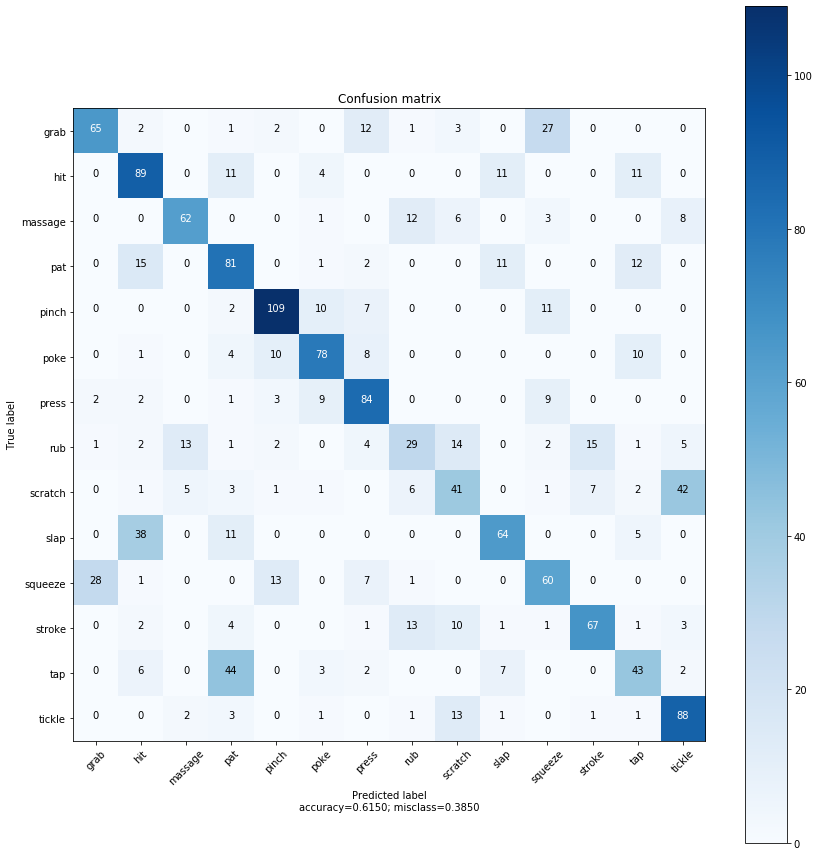

In [0]:
plot_confusion_matrix(cm, products, normalize=False)

### 5.2b Confusion matrix 2nd way

In [0]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 65   2   0   1   2   0  12   1   3   0  27   0   0   0]
 [  0  89   0  11   0   4   0   0   0  11   0   0  11   0]
 [  0   0  62   0   0   1   0  12   6   0   3   0   0   8]
 [  0  15   0  81   0   1   2   0   0  11   0   0  12   0]
 [  0   0   0   2 109  10   7   0   0   0  11   0   0   0]
 [  0   1   0   4  10  78   8   0   0   0   0   0  10   0]
 [  2   2   0   1   3   9  84   0   0   0   9   0   0   0]
 [  1   2  13   1   2   0   4  29  14   0   2  15   1   5]
 [  0   1   5   3   1   1   0   6  41   0   1   7   2  42]
 [  0  38   0  11   0   0   0   0   0  64   0   0   5   0]
 [ 28   1   0   0  13   0   7   1   0   0  60   0   0   0]
 [  0   2   0   4   0   0   1  13  10   1   1  67   1   3]
 [  0   6   0  44   0   3   2   0   0   7   0   0  43   2]
 [  0   0   2   3   0   1   0   1  13   1   0   1   1  88]]
Normalized confusion matrix
[[0.58 0.02 0.   0.01 0.02 0.   0.11 0.01 0.03 0.   0.24 0.   0.   0.  ]
 [0.   0.71 0.   0.09 0.   0.03 

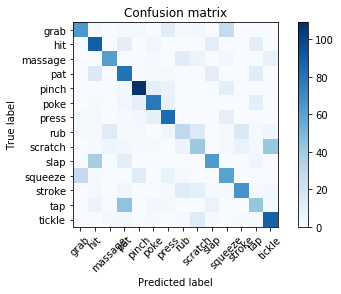

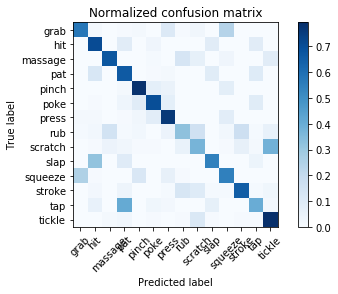

In [0]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, pred_max)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, products)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, products, title='Normalized confusion matrix')

plt.show()